# Compare methods using Hagai data

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import functools
import numpy as np
import logging
import scanpy as sc
import pickle as pkl
import statsmodels.api as sm
from joblib import Parallel, delayed
from functools import partial
import sklearn.linear_model as lm

pd.set_option('display.max_rows', 100)

In [4]:
data_path = '/data_volume/memento/hagai/'

In [5]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

### Functions for replication rate and false positive rate

In [39]:
datasets = [
    'Hagai2018_mouse-lps',
    'Hagai2018_mouse-pic',
    'Hagai2018_pig-lps',
    'Hagai2018_rabbit-lps',
    'Hagai2018_rat-lps',
    'Hagai2018_rat-pic',
]

bulk_methods = [
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
]

sc_methods = [ 
    ('quasiGLM',['coef', 'pval', 'fdr']),
    ('edger_lrt',['logFC', 'PValue', 'FDR']),
    ('edger_qlft',['logFC', 'PValue', 'FDR']),
    ('deseq2_wald',['log2FoldChange', 'pvalue', 'padj']),
    ('deseq2_lrt',['log2FoldChange', 'pvalue', 'padj']),

    # ('MAST', ['coef', 'Pr(>Chisq)','fdr']),
    ('t',['coef', 'pval', 'fdr']),
    ('MWU',['coef', 'pval', 'fdr']),
]

In [40]:
def read_bulk_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path + 'bulk_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    # df.index = df['gene']
    return df

def read_sc_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    
    # if method == 'memento':
    #     df['fdr'] = -df['coef'].abs()
    # # df.index = df['gene']
    return df

def read_sampled_dataset(dataset, method, cols):
    
    df = pd.read_csv(data_path +  'sc_rnaseq/results/{}_100_{}.csv'.format(dataset, method), index_col=0)[cols]
    df.columns = ['coef','pval', 'fdr']
    # df.index = df['gene']
    return df

def concordance_auc(refs, x, k=5):
    count = 0
    for i in range(1, k+1):
        
        ref_total = 0
        for ref in refs:
            ref_total += len(set(x[:i]) & set(ref[:i]))
            
        count += ref_total/len(refs)
        
    return count / (k*(k+1)/2)

all_results = []
small_results = []
for dataset in datasets:
    
    condition = dataset.split('-')[-1] + '4'
    
    dispersion = pd.read_csv(data_path + f'sc_rnaseq/results/{dataset}_dispersions.csv', index_col=0)
    dispersion = dispersion.set_index('gene')
    
    bulk_results = [read_bulk_dataset(dataset, method, cols) for method, cols in bulk_methods]
    sc_results = [read_sc_dataset(dataset, method, cols) for method, cols in sc_methods]
    sampled_results = [read_sampled_dataset(dataset, method, cols) for method, cols in sc_methods]

    gene_list = [set(res.index) for res in sc_results] + [set(res.index) for res in bulk_results] + [set(res.index) for res in sampled_results]
    genes = list(functools.reduce(lambda x,y: x & y, gene_list))

    bulk_results = [res.loc[genes].sort_values('fdr') for res in bulk_results]
    sc_results = [res.loc[genes].sort_values('fdr') for res in sc_results]
    sampled_results = [res.loc[genes].sort_values('fdr') for res in sampled_results]


    scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sc_results)]
    sampled_scores = [(sc_methods[idx][0], dataset, concordance_auc([b_res.index for b_res in bulk_results], res.index, k=100)) for idx, res in enumerate(sampled_results)]
    all_results+=scores
    small_results += sampled_scores
    
    
    # print(dispersion.mean())

In [41]:
df = pd.DataFrame(all_results, columns=['name', 'dataset', 'auc'])
small_df = pd.DataFrame(small_results, columns=['name', 'dataset', 'auc'])

In [42]:
df_cano = pd.read_csv('../canogamez/cano.csv')
small_df_cano = pd.read_csv('../canogamez/small_cano.csv')

In [43]:
combined = pd.concat([df, df_cano]).replace('quasiGLM', 'memento')
small_combined = pd.concat([small_df, small_df_cano]).replace('quasiGLM', 'memento')

combined['cell count'] = 'all'
small_combined['cell count']= '100'

In [44]:
merged = pd.concat([combined, small_combined])

Text(0.5, 1.0, 'Bulk RNA-seq comparison')

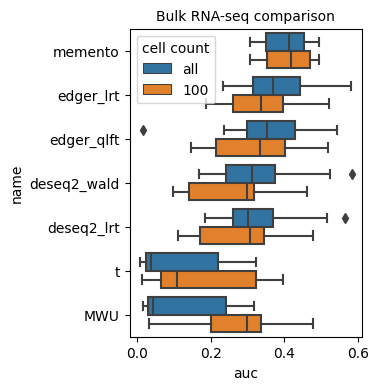

In [45]:
plt.figure(figsize=(3, 4))
sns.boxplot(y='name', x='auc', hue='cell count', data=merged)
# sns.stripplot(y='name', x='auc', hue='cell count', data=merged, color='grey')
plt.title('Bulk RNA-seq comparison')

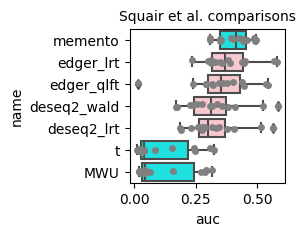

In [49]:
plt.figure(figsize=(2, 2))
my_pal = {
    "memento": "cyan", 
    "edger_lrt": "pink", 
    "edger_qlft":"pink",
    "deseq2_wald":"pink",
    "deseq2_lrt":"pink",
    "t":"cyan",
    "MWU":"cyan"
}
sns.boxplot(y='name', x='auc', data=combined, palette=my_pal)
sns.stripplot(y='name', x='auc', data=combined, color='grey')
plt.title('Squair et al. comparisons')
plt.savefig('squair_comparison.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Bulk RNA-seq comparison using 100 cells')

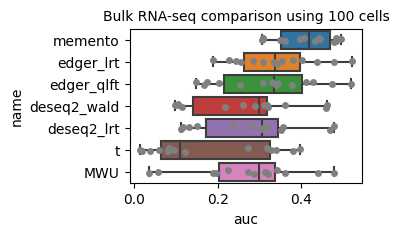

In [47]:
plt.figure(figsize=(3, 2))

sns.boxplot(y='name', x='auc', data=small_combined)
sns.stripplot(y='name', x='auc', data=small_combined, color='grey')
plt.title('Bulk RNA-seq comparison using 100 cells')